
# Лабораторная работа №5

## Ансамбли моделей машинного обучения

##### Выполнил: Борисочкин М. И., РТ5-61Б


### Текстовое описание набора данных

Для обучения моделей был выбран набор данных по недельным продажам в сети магазинов Walmart, предобработанный в [предыдущей лабораторной работе](https://github.com/RDcool/BMSTU_TMO/blob/main/Lab%204/Lab%204.ipynb). Данный датасет предполагает решение задачи регресии.

В данном наборе данных присутствуют следующие столбцы:
- Store — номер магазина;
- Week — номер недели в году;
- Year — год;
- Holiday_Flag — бинарный признак отсутствия/наличния (0/1) праздника;
- Temperature — температура в день продаж;
- CPI — [индекс потребительских цен](https://ru.wikipedia.org/wiki/Индекс_потребительских_цен);
- Unemployment — показатель безработицы;
- Weekly_Sales — недельные продажи магазина. Является целевым признаком.


### Импорт библиотек


In [1]:
from IPython.core.display import HTML
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import Pool, CatBoostRegressor
from gmdhpy.gmdh import Regressor
from gmdhpy.plot_model import PlotModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

%matplotlib inline
sns.set(style='whitegrid')


### Загрузка данных

In [2]:
# Загрузка датасета
data : pd.DataFrame = pd.read_csv('data/Walmart_corrected.csv')


### Разведочный анализ данных

In [3]:
# Первые пять строк датасета
data.head()

,Store,Week,Year,Holiday_Flag,Temperature,CPI,Unemployment,Weekly_Sales
0,1,5,2010,0,42.31,211.096358,8.106,1643690.90
1,1,6,2010,1,38.51,211.242170,8.106,1641957.44
2,1,7,2010,0,39.93,211.289143,8.106,1611968.17
3,1,8,2010,0,46.63,211.319643,8.106,1409727.59
4,1,9,2010,0,46.50,211.350143,8.106,1554806.68


In [4]:
# Последние пять строк датасета
data.tail()

,Store,Week,Year,Holiday_Flag,Temperature,CPI,Unemployment,Weekly_Sales
5793,45,39,2012,0,64.88,192.013558,8.684,713173.95
5794,45,40,2012,0,64.89,192.170412,8.667,733455.07
5795,45,41,2012,0,54.47,192.327265,8.667,734464.36
5796,45,42,2012,0,56.47,192.330854,8.667,718125.53
5797,45,43,2012,0,58.85,192.308899,8.667,760281.43


In [5]:
# Размер датасета
data.shape

(5798, 8)

In [6]:
# Типы столбцов
data.dtypes

Store             int64
Week              int64
Year              int64
Holiday_Flag      int64
Temperature     float64
CPI             float64
Unemployment    float64
Weekly_Sales    float64
dtype: object

In [7]:
# Пустые значения
data.isnull().sum()

Store           0
Week            0
Year            0
Holiday_Flag    0
Temperature     0
CPI             0
Unemployment    0
Weekly_Sales    0
dtype: int64

In [8]:
# Дублирующиеся значения
data.duplicated().sum()

0

In [9]:
# Статистические характеристки датасета
data.describe()

,Store,Week,Year,Holiday_Flag,Temperature,CPI,Unemployment,Weekly_Sales
count,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5.798000e+03
mean,22.783029,25.684719,2010.947051,0.068817,60.308706,175.879731,7.745360,1.033232e+06
std,13.083199,14.062318,0.795531,0.253164,18.314596,38.954099,1.167754,5.500320e+05
min,1.000000,1.000000,2010.000000,0.000000,7.460000,126.064000,4.781000,2.099862e+05
25%,11.000000,14.000000,2010.000000,0.000000,46.970000,132.870839,6.906000,5.499950e+05
50%,22.000000,25.000000,2011.000000,0.000000,62.395000,190.862309,7.852000,9.403524e+05
75%,34.000000,37.000000,2012.000000,0.000000,74.595000,214.015624,8.494000,1.424432e+06
max,45.000000,52.000000,2012.000000,1.000000,100.140000,227.232807,10.641000,2.685352e+06


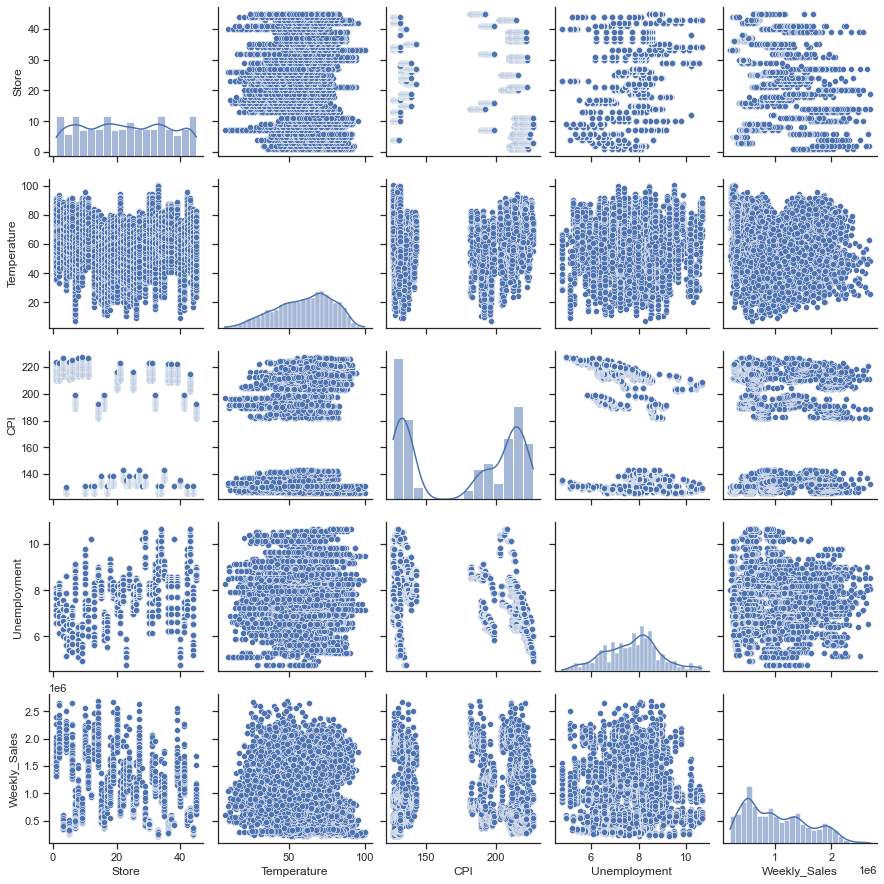

In [10]:
# Парные диаграммы
with sns.axes_style('ticks'):
    sns.pairplot(data=data[['Store', 'Temperature', 'CPI', 'Unemployment', 'Weekly_Sales']],
                 diag_kws=dict(kde=True))
    plt.show()

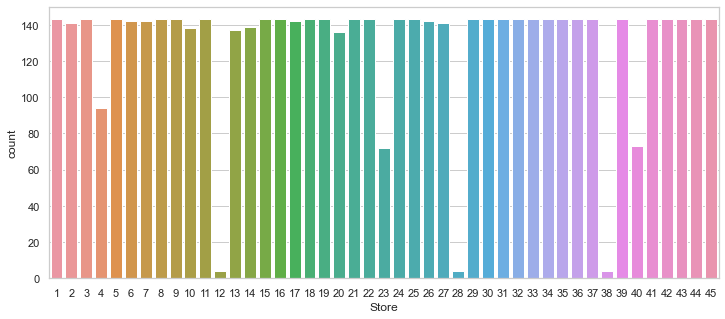

In [11]:
# Распределение по магазинам
_, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=data['Store'], ax=ax)
plt.show()

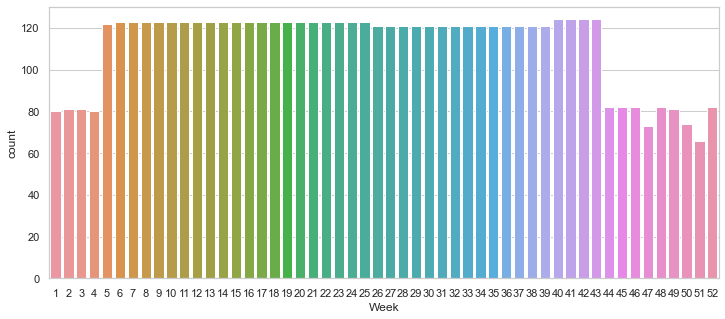

In [12]:
# Распределение по неделям
_, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=data['Week'], ax=ax)
plt.show()

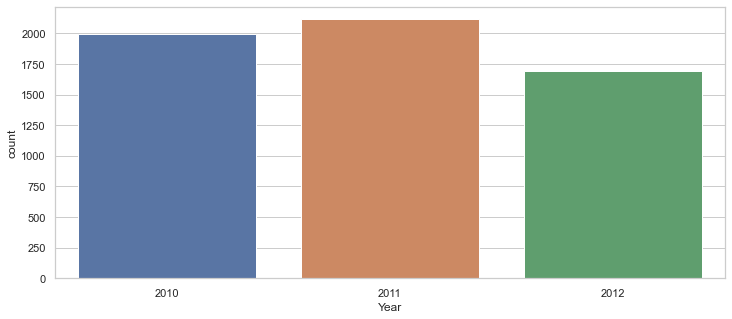

In [13]:
# Распределение по годам
_, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=data['Year'], ax=ax)
plt.show()

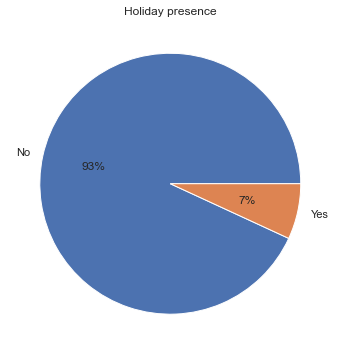

In [14]:
# Распределение праздников
_, ax = plt.subplots(figsize=(6,6))
plt.pie(data['Holiday_Flag'].value_counts(), labels=['No', 'Yes'], autopct='%.0f%%')
plt.title('Holiday presence')
plt.show()

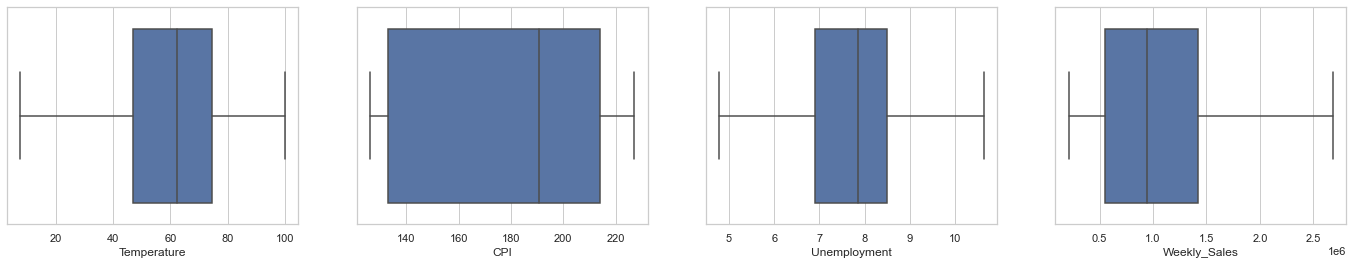

In [15]:
# Ящики с усами для числовых столбцов
_, ax = plt.subplots(1, 4, figsize=(24, 4))
sns.boxplot(x=data['Temperature'], ax=ax[0])
sns.boxplot(x=data['CPI'], ax=ax[1])
sns.boxplot(x=data['Unemployment'], ax=ax[2])
sns.boxplot(x=data['Weekly_Sales'], ax=ax[3])
plt.show()

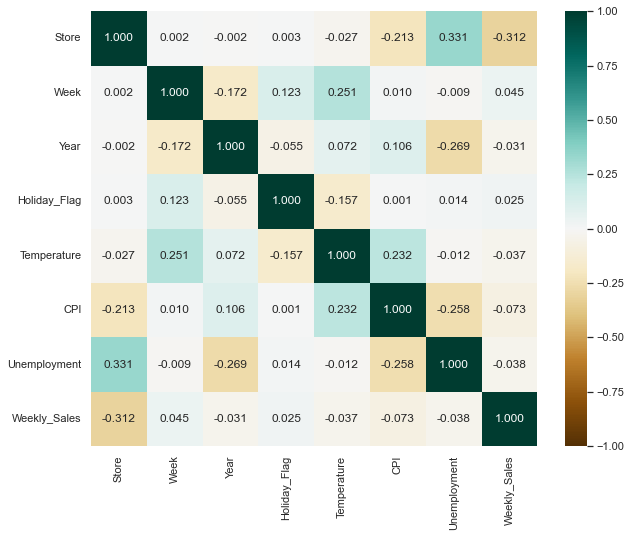

In [16]:
# Тепловая карта корреляционной матрицы
plt.figure(figsize=(10,8))
sns.heatmap(data=data.corr(), vmin=-1, vmax=1, annot=True, fmt='.3f', cmap='BrBG')
plt.show()


### Разбиение выборки


In [17]:
X = data.drop(columns=['Weekly_Sales'])
y = data['Weekly_Sales']

X_train : pd.DataFrame
X_test : pd.DataFrame
y_train : pd.Series
y_test : pd.Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [18]:
# Размер обучающей выборки
X_train.shape, y_train.shape

((4638, 7), (4638,))

In [19]:
# Размер тестовой выборки
X_test.shape, y_test.shape

((1160, 7), (1160,))


### Обучение моделей


In [20]:
# Список моделей и списки метрик
model_list =[]
mae_list = []
mse_list = []
r2_list = []

In [21]:
def plot_feature_importances(feature_names, tree_model):
    """
    Функция визуализации важности признаков

    :param feature_names: Названия признаков
    :param tree_model: Модель
    """
    feature_importance_list = list(zip(feature_names, tree_model.feature_importances_))
    sorted_list = sorted(feature_importance_list, key=itemgetter(1), reverse=True)
    feature_order = [x for x, _ in sorted_list]

    plt.figure(figsize=(9,6))
    bar_plot = sns.barplot(x=feature_names, y=tree_model.feature_importances_,
                           order=feature_order)
    bar_plot.bar_label(bar_plot.containers[-1], fmt='%.3f')
    plt.show()

In [22]:
def generate_tree_graph(estimator, filename):
    """
    Функция для создания графа дерева

    :param estimator: Модель
     :param filename: Название файла с графом
    """
    dot_data = export_graphviz(estimator, feature_names=list(X_train.columns),
                               filled=True, rounded=True, special_characters=True, rotate=True)
    graph = graphviz.Source(dot_data, format='svg', directory='images', filename=filename,
                            engine='dot')
    graph.render()


#### Бэггинг

In [23]:
# Обучение модели
bg_regressor = BaggingRegressor(n_estimators=20, oob_score=True, random_state=7)
bg_regressor.fit(X_train, y_train)

BaggingRegressor(n_estimators=20, oob_score=True, random_state=7)

In [24]:
# Out-of-bag error, возвращаемый регрессором
# Для регресии используется метрика r2
bg_regressor.oob_score_

0.9619115299378256

In [25]:
# Предсказание, сделанное моделью
bg_pred = bg_regressor.predict(X_test)

In [26]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('Bagging')
mae_list.append(mean_absolute_error(y_test, bg_pred))
mse_list.append(mean_squared_error(y_test, bg_pred))
r2_list.append(r2_score(y_test, bg_pred))


#### Случайный лес


In [27]:
# Обучение модели
rf_regressor = RandomForestRegressor(n_estimators=20, criterion='absolute_error', oob_score=True, random_state=7)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=20,
                      oob_score=True, random_state=7)

In [28]:
# Out-of-bag error, возвращаемый регрессором
rf_regressor.oob_score_

0.9580507980905749

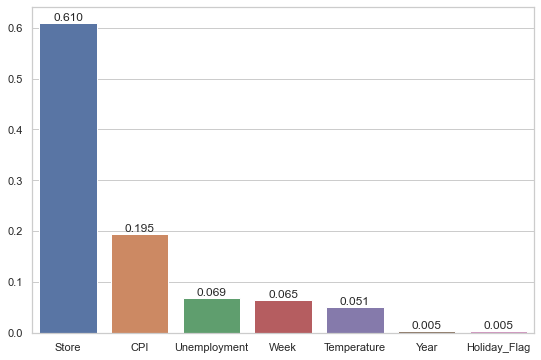

In [29]:
# Важность признаков случайного леса
plot_feature_importances(X.columns.values, rf_regressor)

In [30]:
# Предсказание, сделанное моделью
rf_pred = rf_regressor.predict(X_test)

In [31]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('Random Forest')
mae_list.append(mean_absolute_error(y_test, rf_pred))
mse_list.append(mean_squared_error(y_test, rf_pred))
r2_list.append(r2_score(y_test, rf_pred))


#### Сверхслучайные деревья


In [32]:
# Обучение модели
et_regressor = ExtraTreesRegressor(n_estimators=20, bootstrap=True,
                                   criterion='absolute_error', oob_score=True, random_state=7)
et_regressor.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, criterion='absolute_error', n_estimators=20,
                    oob_score=True, random_state=7)

In [33]:
# Out-of-bag error, возвращаемый регрессором
et_regressor.oob_score_

0.9522711582327434

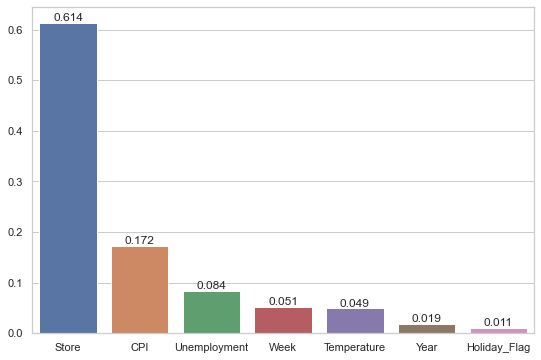

In [34]:
# Важность признаков сверхслучайных деревьев
plot_feature_importances(X.columns.values, et_regressor)

In [35]:
# Предсказание, сделанное моделью
et_pred = et_regressor.predict(X_test)

In [36]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('Extra Trees')
mae_list.append(mean_absolute_error(y_test, et_pred))
mse_list.append(mean_squared_error(y_test, et_pred))
r2_list.append(r2_score(y_test, et_pred))


### AdaBoost


In [37]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'n_estimators' : np.arange(10, 51, 10),
                      'learning_rate': np.linspace(0.5, 2.5, 5),
                      'loss': ['linear', 'square', 'exponential']}

In [38]:
%%time
# Оптимизация гиперпараметров
ab_gs = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), random_state=7),
                     parameters_to_tune, cv=10, scoring='neg_mean_absolute_error')
ab_gs.fit(X_train, y_train)

CPU times: total: 1min 40s
Wall time: 1min 40s


GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                                         random_state=7),
             param_grid={'learning_rate': array([0.5, 1. , 1.5, 2. , 2.5]),
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': array([10, 20, 30, 40, 50])},
             scoring='neg_mean_absolute_error')

In [39]:
# Лучшее значение параметров
ab_gs.best_params_

{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 50}

In [40]:
# Лучшее значение метрики
-ab_gs.best_score_

165785.07874778626

In [41]:
# Обучение модели
ab_regressor : AdaBoostRegressor = ab_gs.best_estimator_
ab_regressor.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                  loss='square', random_state=7)

In [42]:
# Пример дерева из AdaBoost
generate_tree_graph(ab_regressor.estimators_[0], 'ab_tree')
HTML('<img src="images/ab_tree.svg" width=100%>')

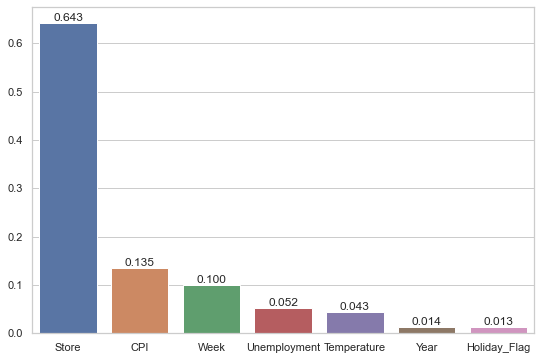

In [43]:
# Важность признаков AdaBoost
plot_feature_importances(X.columns.values, ab_regressor)

In [44]:
# Предсказание, сделанное моделью
ab_pred = ab_regressor.predict(X_test)

In [45]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('AdaBoost')
mae_list.append(mean_absolute_error(y_test, ab_pred))
mse_list.append(mean_squared_error(y_test, ab_pred))
r2_list.append(r2_score(y_test, ab_pred))


#### Градиентный бустинг

##### С помощью библиотеки scikit-learn

In [46]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
                      'learning_rate': np.linspace(0.1, 0.5, 5),
                      'n_estimators' : np.arange(10, 51, 10),
                      'max_depth' : [3, 4, 5]}

In [47]:
%%time
# Оптимизация гиперпараметров
gb_gs = GridSearchCV(GradientBoostingRegressor(random_state=7), parameters_to_tune,
                     cv=5, scoring='neg_mean_absolute_error')
gb_gs.fit(X_train, y_train)

CPU times: total: 4min 37s
Wall time: 4min 38s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=7),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'loss': ['squared_error', 'absolute_error', 'huber',
                                  'quantile'],
                         'max_depth': [3, 4, 5],
                         'n_estimators': array([10, 20, 30, 40, 50])},
             scoring='neg_mean_absolute_error')

In [48]:
# Лучшее значение параметров
gb_gs.best_params_

{'learning_rate': 0.5,
 'loss': 'squared_error',
 'max_depth': 5,
 'n_estimators': 50}

In [49]:
# Лучшее значение метрики
-gb_gs.best_score_

53477.49474279738

In [50]:
# Обучение модели
gb_regressor : GradientBoostingRegressor = gb_gs.best_estimator_
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=5, n_estimators=50,
                          random_state=7)

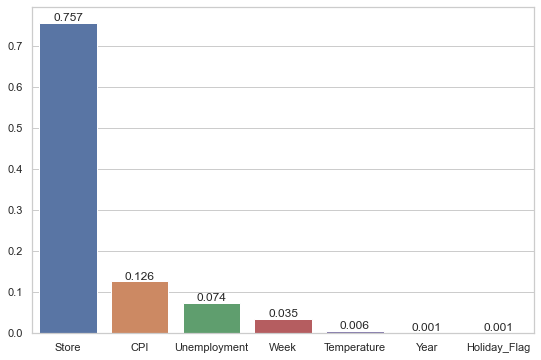

In [51]:
# Важность признаков градиентного бустинга
plot_feature_importances(X.columns.values, gb_regressor)

In [52]:
# Предсказание, сделанное моделью
gb_pred = gb_regressor.predict(X_test)

In [53]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('Gradient Boosting')
mae_list.append(mean_absolute_error(y_test, gb_pred))
mse_list.append(mean_squared_error(y_test, gb_pred))
r2_list.append(r2_score(y_test, gb_pred))


##### С помощью библиотеки CatBoost


In [54]:
# Тренировочный Pool
train_pool = Pool(X_train, y_train, cat_features=['Store'])

In [55]:
# Создание CatBoost-регрессора
cb_regressor = CatBoostRegressor(eval_metric='MAE', logging_level='Silent', random_seed=7)

In [56]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'iterations' : np.arange(10, 51, 10),
                      'learning_rate': np.linspace(0.1, 0.5, 5),
                      'depth' : [3, 4, 5]}

In [57]:
%%time
# Оптимизация гиперпараметров и обучение модели
cb_gs = cb_regressor.grid_search(param_grid=parameters_to_tune, X=train_pool, cv=10,
                                 calc_cv_statistics=True, search_by_train_test_split=True,
                                 verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 40.5 s
Wall time: 21.1 s


In [58]:
# Лучшее значение параметров
cb_gs['params']

{'depth': 5, 'iterations': 50, 'learning_rate': 0.5}

In [59]:
# Лучшее значение метрики
cb_regressor.best_score_

{'learn': {'MAE': 78590.49486714366, 'RMSE': 113397.82629958454}}

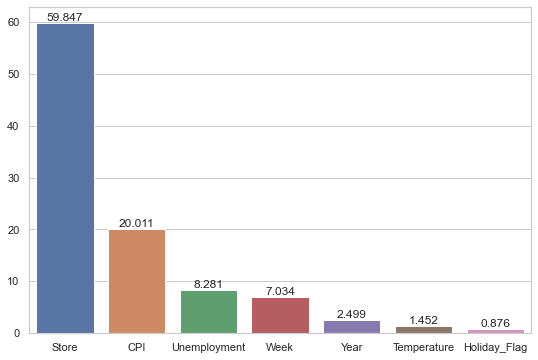

In [60]:
# Важность признаков градиентного бустинга (CatBoost)
plot_feature_importances(X.columns.values, cb_regressor)

In [61]:
# Предсказание, сделанное моделью
cb_pred = cb_regressor.predict(X_test)

In [62]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('CatBoost')
mae_list.append(mean_absolute_error(y_test, cb_pred))
mse_list.append(mean_squared_error(y_test, cb_pred))
r2_list.append(r2_score(y_test, cb_pred))


#### Стекинг

В библиотеке scikit-learn присутствует метод стекинга с версии 0.22 (Декабрь 2019). [Официальный пример применения](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py)

Мы будем "стекать" две лучшие модели из предыдущей лабораторной работы: дерево решений и полиномиальную регрессию, и две худшие на данный момент модели из данной: AdaBoost и сверхслучайные деревьев. Значения оптимальных гиперпараметров для неансамблевых возьмём оттуда же, откуда и модели. В качестве модели второго уровня возьмём гребневую регрессию.

In [63]:
# Полиномиальная регрессия
pr_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=5), LinearRegression())

In [64]:
# Дерево решений
dt = DecisionTreeRegressor(criterion='absolute_error', max_depth=8,
                           max_features=0.8, min_samples_leaf=0.01, random_state=8)

In [65]:
# Значения коэффициента альфа
alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [66]:
# Обучение модели
estimators = [
    ('Polynomial Regression', pr_pipeline),
    ('Decision Tree', dt),
    ('AdaBoost', ab_regressor),
    ('Extra Trees', et_regressor)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(alphas))
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('Polynomial Regression',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('polynomialfeatures',
                                                PolynomialFeatures(degree=5)),
                                               ('linearregression',
                                                LinearRegression())])),
                              ('Decision Tree',
                               DecisionTreeRegressor(criterion='absolute_error',
                                                     max_depth=8,
                                                     max_features=0.8,
                                                     min_samples_leaf=0.01,
                                                     random_state=8)),
                              ('AdaBoost',
                               AdaBoostRegressor(base_estimator=De

In [67]:
# Предсказание, сделанное моделью
st_pred = stacking_regressor.predict(X_test)

In [68]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('Stacking')
mae_list.append(mean_absolute_error(y_test, st_pred))
mse_list.append(mean_squared_error(y_test, st_pred))
r2_list.append(r2_score(y_test, st_pred))


#### Многослойный перцептрон


In [69]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'mlpregressor__hidden_layer_sizes' : [(80, 60), (80, 60, 20)],
                      'mlpregressor__learning_rate_init' : [1.0, 2.5, 5.0],
                      'mlpregressor__n_iter_no_change' : np.arange(10, 71, 20)}

In [70]:
# Конвейер MLP
mlp_pipeline = make_pipeline(StandardScaler(), MLPRegressor(max_iter=1500, random_state=7))

In [71]:
%%time
# Оптимизация гиперпараметров
mlp_gs = GridSearchCV(mlp_pipeline, parameters_to_tune,
                      cv=5, scoring='neg_mean_absolute_error')
mlp_gs.fit(X_train, y_train)

CPU times: total: 49min 34s
Wall time: 9min


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpregressor',
                                        MLPRegressor(max_iter=1500,
                                                     random_state=7))]),
             param_grid={'mlpregressor__hidden_layer_sizes': [(80, 60),
                                                              (80, 60, 20)],
                         'mlpregressor__learning_rate_init': [1.0, 2.5, 5.0],
                         'mlpregressor__n_iter_no_change': array([10, 30, 50, 70])},
             scoring='neg_mean_absolute_error')

In [72]:
# Лучшее значение параметров
mlp_gs.best_params_

{'mlpregressor__hidden_layer_sizes': (80, 60),
 'mlpregressor__learning_rate_init': 1.0,
 'mlpregressor__n_iter_no_change': 70}

In [73]:
# Лучшее значение метрики
-mlp_gs.best_score_

91852.8584476629

In [74]:
# Обучение модели
mlp_pregressor = mlp_gs.best_estimator_
mlp_pregressor.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(80, 60),
                              learning_rate_init=1.0, max_iter=1500,
                              n_iter_no_change=70, random_state=7))])

In [75]:
# Количество скрытых слоёв
mlp_pregressor['mlpregressor'].n_layers_ - 2

2

In [76]:
# Предсказание, сделанное моделью
mlp_pred = mlp_pregressor.predict(X_test)

In [77]:
# Запись модели и значений метрик в соответствцющий списки
model_list.append('MLP')
mae_list.append(mean_absolute_error(y_test, mlp_pred))
mse_list.append(mean_squared_error(y_test, mlp_pred))
r2_list.append(r2_score(y_test, mlp_pred))


#### Метод группового учёта аргуметов


In [78]:
# Обучение модели
gmdh_regressor = Regressor(ref_functions=('linear_cov', 'cubic','quadratic'), seq_type='mode4_2',
                            normalize=False, feature_names=X.columns.values, max_layer_count=100)
gmdh_regressor.fit(np.array(X_train), np.array(y_train))

train layer0 in 0.16 sec
train layer1 in 0.21 sec
train layer2 in 0.20 sec
train layer3 in 0.23 sec
train layer4 in 0.22 sec
train layer5 in 0.47 sec
train layer6 in 0.19 sec
train layer7 in 0.21 sec
train layer8 in 0.19 sec


In [79]:
# Предсказание, сделанное моделью
gmdh_pred = gmdh_regressor.predict(np.array(X_test))

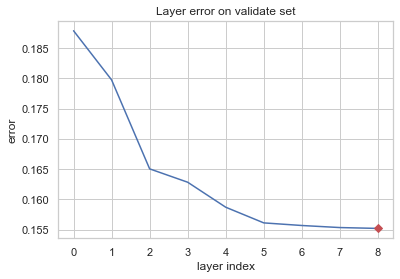

In [80]:
# График ошибки слоя
gmdh_regressor.plot_layer_error()

In [81]:
# График сети
PlotModel(gmdh_regressor, filename='images/gmdh', plot_neuron_name=True).plot()
HTML('<img src="images/gmdh.svg" height=100%>')

In [82]:
# Значения метрик
print('MAE: {};'.format(mean_absolute_error(y_test, gmdh_pred)))
print('MSE: {};'.format(mean_squared_error(y_test, gmdh_pred)))
print('R2: {}.'.format(r2_score(y_test, gmdh_pred)))

MAE: 389335.4810153842;
MSE: 217191713835.52625;
R2: 0.27153299803089437.


Значения полученных метрик сильно отличаются от предполагемых, что говорит либо о недостаточности полинома 3-ей степени, либо о некой сырости библиотеки. Они не будут включены в конечное сравнение.


### Оценка качества моделей


In [83]:
def plot_metrics(models_list, metrics_list, metric_name):
    """
    Функция визуализации метрик

    :param models_list: Список моделей
    :param metrics_list: Список метрик
    :param metric_name: Название метрики
    """
    model_metric_list = list(zip(models_list, metrics_list))
    sorted_list = sorted(model_metric_list, key=itemgetter(1))
    feature_order = [x for x, _ in sorted_list]

    with sns.axes_style('ticks'):
        plt.figure(figsize=(12,6))
        bar_plot = sns.barplot(x=metrics_list, y=models_list,
                               order=feature_order)
        bar_plot.bar_label(bar_plot.containers[-1],label_type='center', fmt='%.3f')
        plt.title(metric_name)
        plt.show()

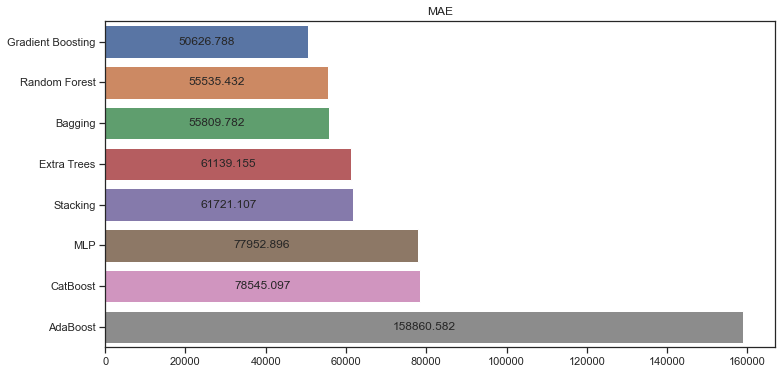

In [84]:
# Сравнение MAE
plot_metrics(model_list, mae_list, 'MAE')

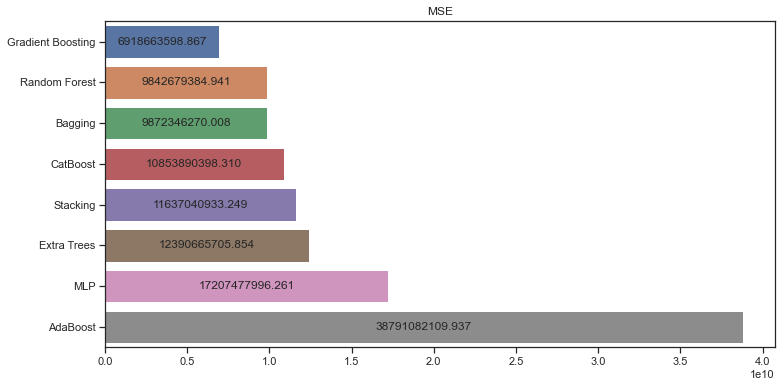

In [85]:
# Сранение MSE
plot_metrics(model_list, mse_list, 'MSE')

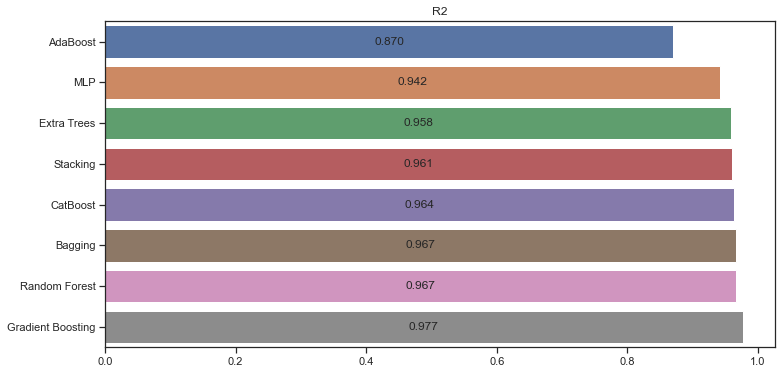

In [86]:
# Сравнение R2
plot_metrics(model_list, r2_list, 'R2')

Из результатов, представленных выше, можно сделать следующие выводы:
- Лучшей моделью оказался градиентный бустинг (из scikit-learn). На втором месте — случайный лес, а на третьем — модель бэггинга;
- Градиентный бустинг из CatBoost дал результаты несколько ниже, чем аналогичная модель из scikit-learn. Но стоит отметить, что решетчатый поиск (и обучение модели) быстрее в CatBoost, да и гиперпараметров для оптимизации модели больше;
- Стэкинг показал, что является "технологией последней мили", улучшив результат всего на 0,003 (R2);
- Многослойный перцептрон, хоть и хуже большинства моделей, показал хороший результат. Тут ситуция похожа на модель из CatBoost: наличие большого количества гиперпараметров для оптимизации.